In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# Prophet

In [2]:
LOCATION = "Nelson St"

In [3]:
cycle_counts = pd.read_csv("cycle_counts.csv", parse_dates=["time"])
cycle_counts = cycle_counts[cycle_counts["location"] == LOCATION]

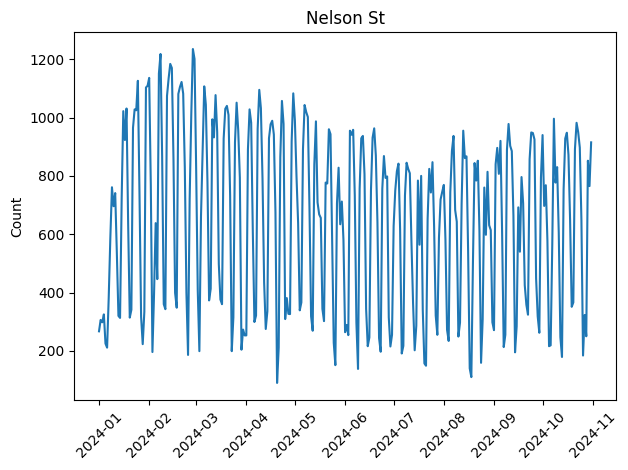

In [4]:
fig, ax = plt.subplots()
ax.plot(cycle_counts["time"], cycle_counts["count"], lw=1.5)
ax.set(title=LOCATION, ylabel="Count")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.tight_layout();

In [5]:
cycle_counts["time"] = pd.to_datetime(cycle_counts["time"])
cycle_counts = cycle_counts.set_index("time").drop(columns=["location"])
cycle_counts = cycle_counts.resample("D").sum().interpolate()

## Fourier Series

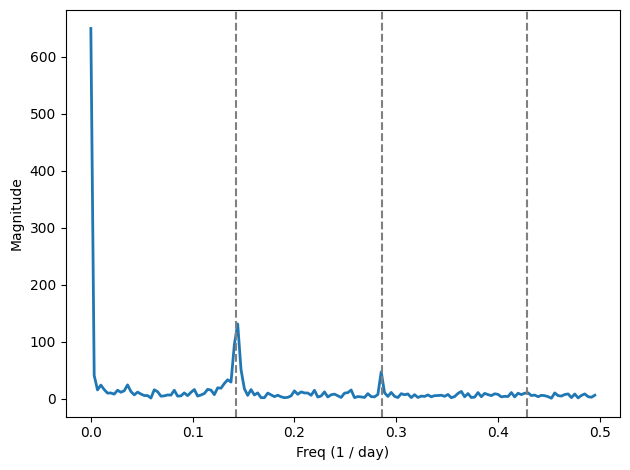

In [6]:
y = np.array(cycle_counts["count"])
n_samples = len(y)

y_fft = np.fft.fft(y)
x_fft = np.fft.fftfreq(n_samples, d=1)  # sampling frequency of 1 / day

# For real valued series, the FFT is symmetric so only plot the positive half of the frequencies
fig, ax = plt.subplots()
ax.plot(
    x_fft[:n_samples // 2],
    1 / n_samples * np.abs(y_fft)[:n_samples // 2],
    lw=2,
)
for i in [1, 2, 3]:
    ax.axvline(i/7, color="grey", ls="--")
ax.set(xlabel="Freq (1 / day)", ylabel="Magnitude")
fig.tight_layout();

In [48]:
# Seaonality as a partial fourier sum

y = np.array(cycle_counts["count"])
y_scaled = y - y.mean()
n_samples = len(y)

period = 7
ks = np.array([1, 2, 3])
ts = np.arange(n_samples).reshape(-1, 1)

X_cos = np.cos(2 * np.pi * ks * ts / period)
X_sin = np.sin(2 * np.pi * ks * ts / period)


def fourier_sum(theta: np.ndarray) -> np.ndarray:
    a0, a1, b1, a2, b2, a3, b3 = theta
    theta_cos = np.array([a1, a2, a3])
    theta_sin = np.array([b1, b2, b3]) 
    return a0 + np.dot(X_cos, theta_cos) + np.dot(X_sin, theta_sin)


def obj(x: np.ndarray):
    y_hat = fourier_sum(x)
    return np.mean((y - y_hat) ** 2)


result = minimize(obj, x0=np.array([1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))
y_hat = fourier_sum(result.x)

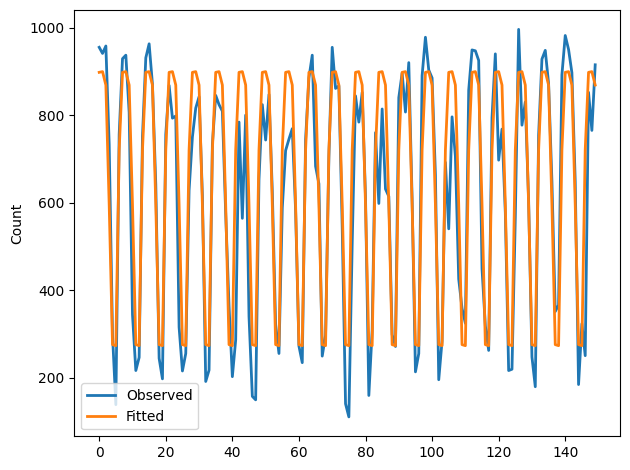

In [55]:
fig, ax = plt.subplots()
n_samples_to_plot = 150
ax.plot(y[-n_samples_to_plot:], label="Observed", lw=2)
ax.plot(y_hat[-n_samples_to_plot:], label="Fitted", lw=2)
ax.set(ylabel="Count")
ax.legend()
fig.tight_layout();

## Prophet Model

In [ ]:
cycle_counts = cycle_counts.reset_index().rename(columns={"time": "ds", "count": "y"})

model = Prophet()
model = model.fit(cycle_counts)

In [ ]:
forecast = model.predict(cycle_counts[["ds"]])
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast);

In [ ]:
# Plotting components

In [ ]:
model.params